***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

Using TensorFlow backend.
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression(random_state=0)
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    roc_auc =auc(fpr, tpr)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

#### Read Data

In [4]:
df=pd.read_csv('../html/HTML.csv',index_col='domain')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df.columns if 'number' in col]
df.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df.shape)

df.Target=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)

Shape of HTML dataset: (43491, 1461)


#### Dropping constants

In [5]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

0 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43491, 1461)


#### 95% same values

In [6]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

1297 columns have more than 95% same values


In [7]:
df.drop(col_values[col_values['95_%_same_values']==True].index.values,axis=1,inplace=True)

In [8]:
df_sel=df.copy(deep=True)
rem=['a_href_absolute','a_href_relative','a_count','a_href_out_of_domain',
     'base_count','base_href_absolute','base_href_out_of_domain',
     'iframe_src_absolute','iframe_src_relative','iframe_sandbox_allow_same_origin_count','iframe_src_http',
     'img_src_absolute','img_src_http','img_srcset_absolute','img_src_relative','img_srcset_relative','img_count',
     'script_src_absolute','script_src_http','script_src_relative','script_count','script_src_https',
     'link_rel_wlwmanifest','link_href_absolute','link_href_relative','link_rel_EditURI','link_count',
     'link_type_application/wlwmanifest+xml','link_href_https','link_rel_stylesheet','link_href_.png',
     'form_action_absolute','form_action_relative','form_count','form_action_https',
     'form_enctype_application/x-www-form-urlencoded',
     'tbody_count',
     'nofollow_count']

df_sel.drop(rem,axis=1,inplace=True)

In [9]:
# X = df_sel.assign(const=1)
# pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns).sort_values()

In [10]:
# rem=['link_rel_wlwmanifest','script_src_absolute','base_count','img_src_relative','link_href_relative',
#      'form_action_absolute','tbody_count','link_count',  'base_href_absolute', 'img_srcset_relative','link_rel_EditURI',
#      'form_enctype_application/x-www-form-urlencoded','a_href_relative','iframe_src_absolute',
#      'iframe_sandbox_allow_same_origin_count','a_href_absolute','base_href_relative','link_type_application/wlwmanifest+xml'
#      ,'form_action_https','form_action_out_of_domain','nofollow_count','img_count','img_src_http','script_src_http',
#      'link_href_http','a_hrefa_http','a_href_out_of_domain','iframe_src_http']

# df.drop(rem,axis=1,inplace=True)

# print("Shape of our dataset:",df.shape)

In [11]:
cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
script_src_.js,-0.319546,0.000000e+00,-142.596194,0.000000e+00
script_async_true,-0.245742,0.000000e+00,-118.214320,0.000000e+00
link_rel_canonical,-0.276351,0.000000e+00,-114.117813,0.000000e+00
div_count,-0.231558,0.000000e+00,-113.026088,0.000000e+00
script_type_text/javascript,-0.264055,0.000000e+00,-111.582561,0.000000e+00
script_src_out_of_domain,-0.246691,0.000000e+00,-106.660880,0.000000e+00
iframe_count,-0.217971,0.000000e+00,-103.168368,0.000000e+00
meta_http-equiv_X-UA-Compatible,-0.236538,0.000000e+00,-93.973108,0.000000e+00
img_src_https,-0.183861,0.000000e+00,-91.083544,0.000000e+00



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


In [12]:
fin_col=num_stats_js.index.values[0:55]

fin_col=fin_col.tolist()

fin_col.append('Target')

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [13]:
train=df_sel[fin_col].iloc[:34793,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel[fin_col].iloc[34793:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [14]:
columns=fin_col
columns.remove('Target')

In [15]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9005834506941052
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26715  2976    29691
True         483  4619     5102
__all__    27198  7595    34793

Accuracy of the model for test data is: 0.8915842722464934
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6621   802     7423
True         141  1134     1275
__all__     6762  1936     8698



Logistic Regression
Accuracy of the model for training data is: 0.876699336073348
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26437  3254    29691
True        1036  4066     5102
__all__    27473  7320    34793

Accuracy of the model for test data is: 0.8654863186939526
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6522   901     7423
True         269  1006     1275
__all__     6791  1907     8698



RandomForest Classifier
Accuracy of the model for training data is: 0.9121087575086942
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26806  2885    29691
True         173  4929     5102
__all__    26979  7814    34793

Accuracy of the model for test data is: 0.8965279374568866
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6647   776     7423
True         124  1151     1275
__all__     6771  1927     8698



Adaoost Classifier
Accuracy of the model for training data is: 0.8828787399764321
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26346  3345    29691
True         730  4372     5102
__all__    27076  7717    34793

Accuracy of the model for test data is: 0.8729593009887331
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6506   917     7423
True         188  1087     1275
__all__     6694  2004     8698



GradientBoosting Classifier
Accuracy of the model for training data is: 0.8980254648923635
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26773  2918    29691
True         630  4472     5102
__all__    27403  7390    34793

Accuracy of the model for test data is: 0.8895148309956312
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6637   786     7423
True         175  1100     1275
__all__     6812  1886     8698



ExtraTree Classifier
Accuracy of the model for training data is: 0.9142068806943926
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26812  2879    29691
True         106  4996     5102
__all__    26918  7875    34793

Accuracy of the model for test data is: 0.8975626580823177
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6653   770     7423
True         121  1154     1275
__all__     6774  1924     8698



Bagging Classifier
Accuracy of the model for training data is: 0.9118213433736672
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26807  2884    29691
True         184  4918     5102
__all__    26991  7802    34793

Accuracy of the model for test data is: 0.8958381237065992
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6635   788     7423
True         118  1157     1275
__all__     6753  1945     8698



Neural Network-1
The accuracy of the model on training data is: 0.8976518265185413


Predicted  False  True  __all__
Actual                         
False      26247  3444    29691
True         117  4985     5102
__all__    26364  8429    34793

The accuracy of the model on test data is: 0.8766383076569326


Predicted  False  True  __all__
Actual                         
False       6433   990     7423
True          83  1192     1275
__all__     6516  2182     8698

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [16]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [17]:
### 55
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.900583,4619.0,26715.0,2976.0,483.0,0.100232,0.094669
LogisticRegression,0.876699,4066.0,26437.0,3254.0,1036.0,0.109596,0.203058
RandomForestClassifier,0.912109,4929.0,26806.0,2885.0,173.0,0.097167,0.033908
AdaBoostClassifier,0.882879,4372.0,26346.0,3345.0,730.0,0.112660,0.143081
GradientBoostingClassifier,0.898025,4472.0,26773.0,2918.0,630.0,0.098279,0.123481
ExtraTreeClassifier,0.914207,4996.0,26812.0,2879.0,106.0,0.096965,0.020776
BaggingClassifier,0.911821,4918.0,26807.0,2884.0,184.0,0.097134,0.036064
Neural Network-1,0.897652,4985.0,26247.0,3444.0,117.0,0.115995,0.022932


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.891584,1134.0,6621.0,802.0,141.0,0.108043,0.110588,0.890685,0.664371
LogisticRegression,0.865486,1006.0,6522.0,901.0,269.0,0.121379,0.210980,0.833820,0.570749
RandomForestClassifier,0.896528,1151.0,6647.0,776.0,124.0,0.104540,0.097255,0.899103,0.679817
AdaBoostClassifier,0.872959,1087.0,6506.0,917.0,188.0,0.123535,0.147451,0.864507,0.612335
GradientBoostingClassifier,0.889515,1100.0,6637.0,786.0,175.0,0.105887,0.137255,0.878429,0.649608
ExtraTreeClassifier,0.897563,1154.0,6653.0,770.0,121.0,0.103732,0.094902,0.900683,0.682890
BaggingClassifier,0.895838,1157.0,6635.0,788.0,118.0,0.106157,0.092549,0.900647,0.680188
Neural Network-1,0.876638,1192.0,6433.0,990.0,83.0,0.133369,0.065098,0.900766,0.653955


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [18]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [19]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [20]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.5941867906099492
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28651  1040    29691
True       23058  6633    29691
__all__    51709  7673    59382

Accuracy of the model for test data is: 0.8361692343067372
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7044   379     7423
True        1046   229     1275
__all__     8090   608     8698



Logistic Regression
Accuracy of the model for training data is: 0.8861944697046243
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24324   5367    29691
True        1391  28300    29691
__all__    25715  33667    59382

Accuracy of the model for test data is: 0.831225569096344
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6024  1399     7423
True          69  1206     1275
__all__     6093  2605     8698



RandomForest Classifier
Accuracy of the model for training data is: 0.9460105755952982
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26712   2979    29691
True         227  29464    29691
__all__    26939  32443    59382

Accuracy of the model for test data is: 0.8958381237065992
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6619   804     7423
True         102  1173     1275
__all__     6721  1977     8698



Adaoost Classifier
Accuracy of the model for training data is: 0.9044491596780169
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25226   4465    29691
True        1209  28482    29691
__all__    26435  32947    59382

Accuracy of the model for test data is: 0.8539894228558289
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6230  1193     7423
True          77  1198     1275
__all__     6307  2391     8698



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9227206897713112
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25828   3863    29691
True         726  28965    29691
__all__    26554  32828    59382

Accuracy of the model for test data is: 0.8703150149459646
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6375  1048     7423
True          80  1195     1275
__all__     6455  2243     8698



ExtraTree Classifier
Accuracy of the model for training data is: 0.946802061230676
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26721   2970    29691
True         189  29502    29691
__all__    26910  32472    59382

Accuracy of the model for test data is: 0.8967578753736491
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6626   797     7423
True         101  1174     1275
__all__     6727  1971     8698



Bagging Classifier
Accuracy of the model for training data is: 0.9457411336768717
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26712   2979    29691
True         243  29448    29691
__all__    26955  32427    59382

Accuracy of the model for test data is: 0.8941135893308807
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6601   822     7423
True          99  1176     1275
__all__     6700  1998     8698



Neural Network-1
The accuracy of the model on training data is: 0.9347950557407969


Predicted  False   True  __all__
Actual                          
False      25910   3781    29691
True          91  29600    29691
__all__    26001  33381    59382

The accuracy of the model on test data is: 0.8650264428604277


Predicted  False  True  __all__
Actual                         
False       6311  1112     7423
True          62  1213     1275
__all__     6373  2325     8698

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [21]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [22]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.594187,6633.0,28651.0,1040.0,23058.0,0.035027,0.776599
LogisticRegression,0.886194,28300.0,24324.0,5367.0,1391.0,0.180762,0.046849
RandomForestClassifier,0.946011,29464.0,26712.0,2979.0,227.0,0.100333,0.007645
AdaBoostClassifier,0.904449,28482.0,25226.0,4465.0,1209.0,0.150382,0.040719
GradientBoostingClassifier,0.922721,28965.0,25828.0,3863.0,726.0,0.130107,0.024452
ExtraTreeClassifier,0.946802,29502.0,26721.0,2970.0,189.0,0.100030,0.006366
BaggingClassifier,0.945741,29448.0,26712.0,2979.0,243.0,0.100333,0.008184
Neural Network-1,0.934795,29600.0,25910.0,3781.0,91.0,0.127345,0.003065


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.836169,229.0,7044.0,379.0,1046.0,0.051058,0.820392,0.564275,0.178317
LogisticRegression,0.831226,1206.0,6024.0,1399.0,69.0,0.188468,0.054118,0.878707,0.584869
RandomForestClassifier,0.895838,1173.0,6619.0,804.0,102.0,0.108312,0.080000,0.905844,0.685036
AdaBoostClassifier,0.853989,1198.0,6230.0,1193.0,77.0,0.160717,0.060392,0.889446,0.617050
GradientBoostingClassifier,0.870315,1195.0,6375.0,1048.0,80.0,0.141183,0.062745,0.898036,0.643627
ExtraTreeClassifier,0.896758,1174.0,6626.0,797.0,101.0,0.107369,0.079216,0.906708,0.687232
BaggingClassifier,0.894114,1176.0,6601.0,822.0,99.0,0.110737,0.077647,0.905808,0.682433
Neural Network-1,0.865026,1213.0,6311.0,1112.0,62.0,0.149805,0.048627,0.900784,0.640622


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [23]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [24]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

Shape after undersampling (10204, 55)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.5737945903567229
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4950   152     5102
True        4197   905     5102
__all__     9147  1057    10204

Accuracy of the model for test data is: 0.8369740170154059
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7054   369     7423
True        1049   226     1275
__all__     8103   595     8698



Logistic Regression
Accuracy of the model for training data is: 0.8834770678165426
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4170   932     5102
True         257  4845     5102
__all__     4427  5777    10204

Accuracy of the model for test data is: 0.8301908484709128
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6013  1410     7423
True          67  1208     1275
__all__     6080  2618     8698



RandomForest Classifier
Accuracy of the model for training data is: 0.942375539004312
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4576   526     5102
True          62  5040     5102
__all__     4638  5566    10204

Accuracy of the model for test data is: 0.8877902966199126
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6528   895     7423
True          81  1194     1275
__all__     6609  2089     8698



Adaoost Classifier
Accuracy of the model for training data is: 0.8963151705213642
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4312   790     5102
True         268  4834     5102
__all__     4580  5624    10204

Accuracy of the model for test data is: 0.8472062543113359
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6155  1268     7423
True          61  1214     1275
__all__     6216  2482     8698



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9096432771462172
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4403   699     5102
True         223  4879     5102
__all__     4626  5578    10204

Accuracy of the model for test data is: 0.862267187859278
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6282  1141     7423
True          57  1218     1275
__all__     6339  2359     8698



ExtraTree Classifier
Accuracy of the model for training data is: 0.9452175617404939
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4583   519     5102
True          40  5062     5102
__all__     4623  5581    10204

Accuracy of the model for test data is: 0.8899747068291561
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6550   873     7423
True          84  1191     1275
__all__     6634  2064     8698



Bagging Classifier
Accuracy of the model for training data is: 0.9415915327322618
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4576   526     5102
True          70  5032     5102
__all__     4646  5558    10204

Accuracy of the model for test data is: 0.8834214762014256
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6487   936     7423
True          78  1197     1275
__all__     6565  2133     8698



Neural Network-1
The accuracy of the model on training data is: 0.9283614268914151


Predicted  False  True  __all__
Actual                         
False       4400   702     5102
True          29  5073     5102
__all__     4429  5775    10204

The accuracy of the model on test data is: 0.8468613474361922


Predicted  False  True  __all__
Actual                         
False       6136  1287     7423
True          45  1230     1275
__all__     6181  2517     8698

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [25]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [26]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.573795,905.0,4950.0,152.0,4197.0,0.029792,0.822619
LogisticRegression,0.883477,4845.0,4170.0,932.0,257.0,0.182673,0.050372
RandomForestClassifier,0.942376,5040.0,4576.0,526.0,62.0,0.103097,0.012152
AdaBoostClassifier,0.896315,4834.0,4312.0,790.0,268.0,0.154841,0.052528
GradientBoostingClassifier,0.909643,4879.0,4403.0,699.0,223.0,0.137005,0.043708
ExtraTreeClassifier,0.945218,5062.0,4583.0,519.0,40.0,0.101725,0.007840
BaggingClassifier,0.941592,5032.0,4576.0,526.0,70.0,0.103097,0.013720
Neural Network-1,0.928361,5073.0,4400.0,702.0,29.0,0.137593,0.005684


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.836974,226.0,7054.0,369.0,1049.0,0.049710,0.822745,0.563772,0.178700
LogisticRegression,0.830191,1208.0,6013.0,1410.0,67.0,0.189950,0.052549,0.878750,0.584106
RandomForestClassifier,0.887790,1194.0,6528.0,895.0,81.0,0.120571,0.063529,0.907950,0.675530
AdaBoostClassifier,0.847206,1214.0,6155.0,1268.0,61.0,0.170820,0.047843,0.890668,0.611965
GradientBoostingClassifier,0.862267,1218.0,6282.0,1141.0,57.0,0.153711,0.044706,0.900791,0.637704
ExtraTreeClassifier,0.889975,1191.0,6550.0,873.0,84.0,0.117607,0.065882,0.908255,0.678834
BaggingClassifier,0.883421,1197.0,6487.0,936.0,78.0,0.126095,0.061176,0.906364,0.668156
Neural Network-1,0.846861,1230.0,6136.0,1287.0,45.0,0.173380,0.035294,0.895663,0.617205


In [27]:
### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [28]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [29]:
df_sel.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df_sel[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 5995 features
EntitySet scattered to workers in 5.104 seconds
Elapsed: 00:45 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [31]:
df_sel.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [32]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [33]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)



X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method

In [34]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(43491, 14)

In [35]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['script_src_.js + script_src_out_of_domain',
 'meta_charset_utf-8 + meta_http-equiv_X-UA-Compatible',
 'link_type_image/png + script_src_.js',
 'link_rel_shortcut icon + meta_charset_utf-8',
 'link_rel_shortcut icon + meta_charset_UTF-8',
 'link_rel_manifest + link_rel_shortcut icon',
 'link_rel_icon + script_src_.js',
 'link_rel_canonical + meta_http-equiv_X-UA-Compatible',
 'link_rel_canonical + meta_charset_UTF-8',
 'link_rel_canonical + link_rel_shortcut icon',
 'link_rel_apple-touch-icon + script_src_.js',
 'link_href_.ico + meta_charset_utf-8',
 'link_href_.ico + link_rel_canonical',
 'iframe_count + script_src_out_of_domain']

In [36]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:34793]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[34793:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [37]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])


feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.8620986980139683
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29472   219    29691
True        4579   523     5102
__all__    34051   742    34793

Accuracy of the model for test data is: 0.8593929638997471
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7342    81     7423
True        1142   133     1275
__all__     8484   214     8698



Logistic Regression
Accuracy of the model for training data is: 0.8533613083091427
Confusion Matrix for training data is:


Predicted      0  1  __all__
Actual                      
0          29691  0    29691
1           5102  0     5102
__all__    34793  0    34793

Accuracy of the model for test data is: 0.8534145780639227
Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0          7423  0     7423
1          1275  0     1275
__all__    8698  0     8698

29691
0
0
29691
5102
0
0
5102
1.0
0.0
0.0
1.0
7423
0
0
7423
1275
0
0
1275
1.0
0.0
0.0
1.0


RandomForest Classifier
Accuracy of the model for training data is: 0.8866438651452878
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26034  3657    29691
True         287  4815     5102
__all__    26321  8472    34793

Accuracy of the model for test data is: 0.8688204184870085
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6397  1026     7423
True         115  1160     1275
__all__     6512  2186     8698



Adaoost Classifier
Accuracy of the model for training data is: 0.8676457908199925
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25988  3703    29691
True         902  4200     5102
__all__    26890  7903    34793

Accuracy of the model for test data is: 0.8575534605656473
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6419  1004     7423
True         235  1040     1275
__all__     6654  2044     8698



GradientBoosting Classifier
Accuracy of the model for training data is: 0.8798896329721496
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26044  3647    29691
True         532  4570     5102
__all__    26576  8217    34793

Accuracy of the model for test data is: 0.8677856978615773
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6414  1009     7423
True         141  1134     1275
__all__     6555  2143     8698



ExtraTree Classifier
Accuracy of the model for training data is: 0.8882246428879372
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26048  3643    29691
True         246  4856     5102
__all__    26294  8499    34793

Accuracy of the model for test data is: 0.8691653253621522
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6399  1024     7423
True         114  1161     1275
__all__     6513  2185     8698



Bagging Classifier
Accuracy of the model for training data is: 0.8865576409047797
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26033  3658    29691
True         289  4813     5102
__all__    26322  8471    34793

Accuracy of the model for test data is: 0.868590480570246
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6396  1027     7423
True         116  1159     1275
__all__     6512  2186     8698



Neural Network-1
The accuracy of the model on training data is: 0.8788262006759753


Predicted  False  True  __all__
Actual                         
False      25973  3718    29691
True         498  4604     5102
__all__    26471  8322    34793

The accuracy of the model on test data is: 0.8654863186939526


Predicted  False  True  __all__
Actual                         
False       6385  1038     7423
True         132  1143     1275
__all__     6517  2181     8698

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [38]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [39]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.862099,523.000000,29472.000000,219.000000,4579.000000,0.007376,0.897491
LogisticRegression,0.853361,25337.150605,4353.849395,4353.849395,748.150605,0.853361,0.146639
RandomForestClassifier,0.886644,4815.000000,26034.000000,3657.000000,287.000000,0.123169,0.056252
AdaBoostClassifier,0.867646,4200.000000,25988.000000,3703.000000,902.000000,0.124718,0.176793
GradientBoostingClassifier,0.879890,4570.000000,26044.000000,3647.000000,532.000000,0.122832,0.104273
ExtraTreeClassifier,0.888225,4856.000000,26048.000000,3643.000000,246.000000,0.122697,0.048216
BaggingClassifier,0.886558,4813.000000,26033.000000,3658.000000,289.000000,0.123202,0.056644
Neural Network-1,0.878826,4604.000000,25973.000000,3718.000000,498.000000,0.125223,0.097609


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.859393,133.000000,7342.000000,81.000000,1142.000000,0.010912,0.895686,0.546701,0.213252
LogisticRegression,0.853415,6334.896413,1088.103587,1088.103587,186.896413,0.853415,0.146585,0.500000,0.000000
RandomForestClassifier,0.868820,1160.000000,6397.000000,1026.000000,115.000000,0.138219,0.090196,0.885792,0.629138
AdaBoostClassifier,0.857553,1040.000000,6419.000000,1004.000000,235.000000,0.135255,0.184314,0.840215,0.567606
GradientBoostingClassifier,0.867786,1134.000000,6414.000000,1009.000000,141.000000,0.135929,0.110588,0.876741,0.618473
ExtraTreeClassifier,0.869165,1161.000000,6399.000000,1024.000000,114.000000,0.137950,0.089412,0.886319,0.630093
BaggingClassifier,0.868590,1159.000000,6396.000000,1027.000000,116.000000,0.138354,0.090980,0.885333,0.628389
Neural Network-1,0.865486,1143.000000,6385.000000,1038.000000,132.000000,0.139836,0.103529,0.878317,0.617418


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [40]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 169.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 169.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 169.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 169.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 169.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

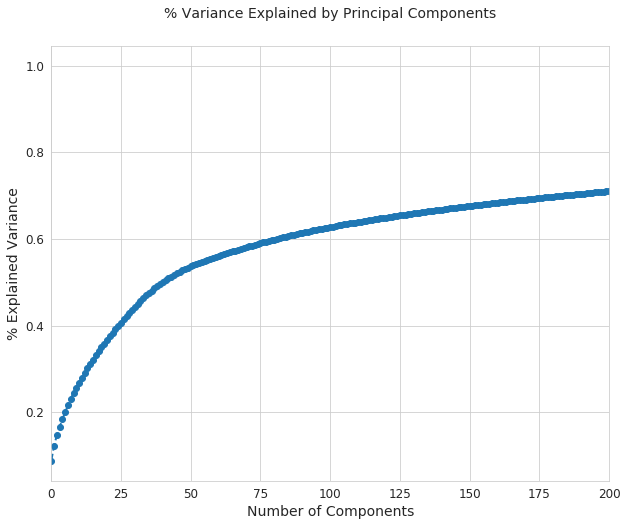

In [41]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [43]:
pca=PCA(n_components=250,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 250 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 250 components is: 0.7360140338537801


In [44]:
X_train=X_pca_21[:34793]
Y_train=fs.iloc[:34793]['Target'].values
X_test=X_pca_21[34793:]
Y_test=fs.iloc[34793:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [45]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,250).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.901301986031673
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26717  2974    29691
True         460  4642     5102
__all__    27177  7616    34793

Accuracy of the model for test data is: 0.8927339618303058
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6619   804     7423
True         129  1146     1275
__all__     6748  1950     8698



Logistic Regression
Accuracy of the model for training data is: 0.8855229500186819
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26365  3326    29691
True         657  4445     5102
__all__    27022  7771    34793

Accuracy of the model for test data is: 0.8723844561968268
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6490   933     7423
True         177  1098     1275
__all__     6667  2031     8698



RandomForest Classifier
Accuracy of the model for training data is: 0.9113902221711264
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26808  2883    29691
True         200  4902     5102
__all__    27008  7785    34793

Accuracy of the model for test data is: 0.8964129684985054
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6658   765     7423
True         136  1139     1275
__all__     6794  1904     8698



Adaoost Classifier
Accuracy of the model for training data is: 0.8957261518121461
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26760  2931    29691
True         697  4405     5102
__all__    27457  7336    34793

Accuracy of the model for test data is: 0.8883651414118188
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6640   783     7423
True         188  1087     1275
__all__     6828  1870     8698



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9009858304831432
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26817  2874    29691
True         571  4531     5102
__all__    27388  7405    34793

Accuracy of the model for test data is: 0.8937686824557369
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6657   766     7423
True         158  1117     1275
__all__     6815  1883     8698



ExtraTree Classifier
Accuracy of the model for training data is: 0.9142068806943926
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26812  2879    29691
True         106  4996     5102
__all__    26918  7875    34793

Accuracy of the model for test data is: 0.8974476891239366
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6659   764     7423
True         128  1147     1275
__all__     6787  1911     8698



Bagging Classifier
Accuracy of the model for training data is: 0.9117638605466617
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26806  2885    29691
True         185  4917     5102
__all__    26991  7802    34793

Accuracy of the model for test data is: 0.8958381237065992
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6644   779     7423
True         127  1148     1275
__all__     6771  1927     8698



Neural Network-1
The accuracy of the model on training data is: 0.9043773172781768


Predicted  False  True  __all__
Actual                         
False      26452  3239    29691
True          88  5014     5102
__all__    26540  8253    34793

The accuracy of the model on test data is: 0.8793975626580823


Predicted  False  True  __all__
Actual                         
False       6462   961     7423
True          88  1187     1275
__all__     6550  2148     8698

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [46]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [47]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.901302,4642.0,26717.0,2974.0,460.0,0.100165,0.090161
LogisticRegression,0.885523,4445.0,26365.0,3326.0,657.0,0.112020,0.128773
RandomForestClassifier,0.911390,4902.0,26808.0,2883.0,200.0,0.097100,0.039200
AdaBoostClassifier,0.895726,4405.0,26760.0,2931.0,697.0,0.098717,0.136613
GradientBoostingClassifier,0.900986,4531.0,26817.0,2874.0,571.0,0.096797,0.111917
ExtraTreeClassifier,0.914207,4996.0,26812.0,2879.0,106.0,0.096965,0.020776
BaggingClassifier,0.911764,4917.0,26806.0,2885.0,185.0,0.097167,0.036260
Neural Network-1,0.904377,5014.0,26452.0,3239.0,88.0,0.109090,0.017248


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.892734,1146.0,6619.0,804.0,129.0,0.108312,0.101176,0.895256,0.670422
LogisticRegression,0.872384,1098.0,6490.0,933.0,177.0,0.125690,0.138824,0.867743,0.614892
RandomForestClassifier,0.896413,1139.0,6658.0,765.0,136.0,0.103058,0.106667,0.895138,0.675969
AdaBoostClassifier,0.888365,1087.0,6640.0,783.0,188.0,0.105483,0.147451,0.873533,0.643186
GradientBoostingClassifier,0.893769,1117.0,6657.0,766.0,158.0,0.103193,0.123922,0.886443,0.663746
ExtraTreeClassifier,0.897448,1147.0,6659.0,764.0,128.0,0.102923,0.100392,0.898342,0.680553
BaggingClassifier,0.895838,1148.0,6644.0,779.0,127.0,0.104944,0.099608,0.897724,0.677469
Neural Network-1,0.879398,1187.0,6462.0,961.0,88.0,0.129462,0.069020,0.900759,0.657386


In [48]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')